# Определение перспективного тарифа для телеком компании

Клиентам компании «Мегалайн» — федерального оператора сотовой связи — предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Сделаем предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод: какой тариф лучше.

### Импорт библиотек

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

**Содержание**

1. [Обзор данных](#start)
2. [Предобработка данных](#preprocessing)
3. [Дополнительные вычисления](#features)
4. [Исследовательский анализ данных](#research)
5. [Статистический анализ данных](#stats)
6. [Проверка гипотез](#hypotheses)
7. [Выводы](#summary)

## Обзор данных<a id='start'></a>

In [2]:
users = pd.read_csv('telecom_users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В `users` хранится информация о пользователях: имя, возраст, город проживания. А также об использовании разных тарифов: название тарифа, дата его подключения и дата прекращения пользования тарифом (значение пропущено, если тариф действовал на момент выгрузки данных).

In [3]:
tariffs = pd.read_csv('telecom_tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В `tariffs` всего две строчки: информация о каждом из двух тарифов. Абонентская плата, количество включенных минут/сообщений/интернет-трафика, стоимость дополнительных минут/сообщений/интернет-трафика.

In [4]:
calls = pd.read_csv('telecom_calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


В `calls` хранится информация о звонках: для каждого пользователя - даты и длительность его звонков.

In [5]:
messages = pd.read_csv('telecom_messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


В `messages` хранится информация о SMS, отправленных каждым пользователем (дата отправки).

In [6]:
internet = pd.read_csv('telecom_internet.csv', index_col = 0)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


В `internet` хранится информация об использовании интернет-трафика: даты сессий и объемы потраченного интернет-трафика.

## Предобработка данных<a id = 'preprocessing'></a>

Проверим типы данных и выясним, как обстоят дела с пропусками.

### Users

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Даты лучше привести к формату datetime:

In [8]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


В столбце `churn_date` для подавляющего большинства клиентов значения отсутствуют. Это значит, что на момент выгрузки данных большинство клиентов еще пользовались выбранным тарифом.

In [9]:
users.user_id.nunique()

500

Все значения в столбце `user_id` уникальны: значит, каждому пользователю соответствует один тариф. Но данных по отказам от тарифов слишком мало, чтобы делать какие-то выводы на их основе.

### Calls

In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [11]:
#приведем даты к формату datetime:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


### Messages

In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [13]:
#приведем даты к формату datetime:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


### Internet

In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [15]:
#приведем даты к формату datetime:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


Проверим, нет ли в данных ошибок и аномальных значений.

### Users

In [16]:
users.age.describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [17]:
users.tariff.value_counts(normalize = True)

smart    0.702
ultra    0.298
Name: tariff, dtype: float64

In [18]:
users.reg_date.describe()

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

В датасете `users` все выглядит нормально. 
- Средний возраст нашей выборки из 500 клиентов - 46 лет. 
- Тариф smart пользуется большей популярностью, чем ultra. 
- В выгрузке содержатся данные за 2018 год.

### Calls

In [19]:
calls.call_date.describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

31 декабря 2018 года было совершено почти 1.5 тысячи звонков: примерно по 3 на каждого из 500 пользователей в нашей выборке. Но это вполне объяснимо: клиенты "Мегалайна" поздравляли своих родных и близких с праздником. В этот день выгодный тариф важен как никогда!

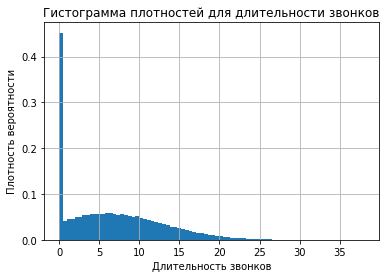

In [20]:
calls.duration.hist(density = True, bins = 80)
plt.title('Гистограмма плотностей для длительности звонков')
plt.xlabel('Длительность звонков')
plt.ylabel('Плотность вероятности');

In [21]:
calls.duration.value_counts(normalize = True).head()

0.00    0.195516
4.49    0.000701
5.50    0.000701
6.15    0.000696
6.38    0.000696
Name: duration, dtype: float64

Почти 20% всех звонков имеют длительность 0 сек. Cкорее всего, это те случаи, когда была попытка установить соединение, но абонент не ответил или сбросил вызов. 

Мы знаем, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Так что недозвоны нам не интересны: в этих случаях минуты, включенные в тариф, не расходуются. 

Значит, мы ничего не потеряем, если удалим такие строки - пустышки:

In [22]:
calls = calls.drop(calls[calls['duration'] == 0].index)

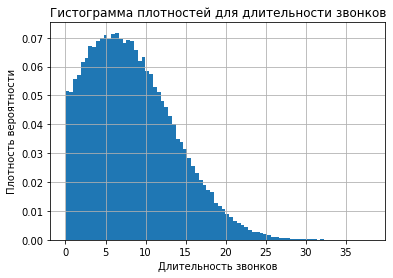

In [23]:
calls.duration.hist(density = True, bins = 80)
plt.title('Гистограмма плотностей для длительности звонков')
plt.xlabel('Длительность звонков')
plt.ylabel('Плотность вероятности');

In [24]:
calls.duration.describe()

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

Абоненты "Мегалайна" довольно много разговаривают по телефону: средняя длительность звонка - около 8 минут.

### Internet

In [25]:
internet.mb_used.describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [26]:
internet.mb_used.value_counts(normalize = True).head()

0.00      0.131182
197.56    0.000060
447.30    0.000060
335.91    0.000060
108.95    0.000054
Name: mb_used, dtype: float64

В столбце с интернет-трафиком 13% значений равны нулю. Но причина появления нулей в этом случае непонятна.

In [27]:
internet.groupby(['user_id', internet.mb_used == 0]).mb_used.count().unstack(level = 1).reset_index()

mb_used,user_id,False,True
0,1000,197.0,14.0
1,1001,82.0,14.0
2,1002,297.0,72.0
3,1003,102.0,2.0
4,1004,278.0,22.0
...,...,...,...
492,1495,244.0,10.0
493,1496,693.0,141.0
494,1497,105.0,16.0
495,1498,191.0,41.0


Нулевые значения объема интернет-трафика встречаются почти у всех пользователей. Какую-то закономерность проследить не удается. В любом случае, нулевые значения не несут для нас полезной информации, как и в случае с недозвонами. Поэтому избавимся от них:

In [28]:
internet = internet.drop(internet[internet.mb_used == 0].index)

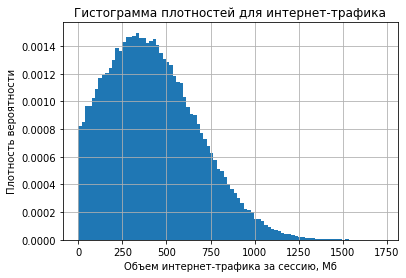

In [29]:
internet.mb_used.hist(density = True, bins = 90)
plt.title('Гистограмма плотностей для интернет-трафика')
plt.xlabel('Объем интернет-трафика за сессию, Мб')
plt.ylabel('Плотность вероятности');

### Распределение по времени

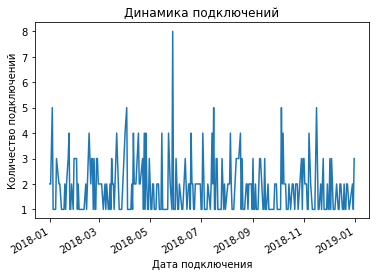

In [30]:
users.groupby('reg_date').user_id.nunique().plot()
plt.title('Динамика подключений')
plt.xlabel('Дата подключения')
plt.ylabel('Количество подключений');

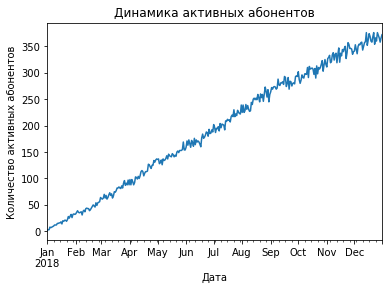

In [31]:
calls.groupby('call_date').user_id.nunique().plot()
plt.title('Динамика активных абонентов')
plt.xlabel('Дата')
plt.ylabel('Количество активных абонентов');

В датасетах содержатся данные о пользователях, которые подключались к тарифам в течение 2018 года. Подключения происходили довольно равномерно, количество пользователей в выборке увеличивалось от месяца к месяцу.

Итак, мы привели данные к типам, удобным для дальнейшей работы, и избавились от аномальных значений.

## Дополнительные вычисления<a id = 'features'></a>

Нас будут интересовать не отдельные события (звонки, отправки SMS, интернет-сессии), а агрегированные данные по пользователям: насколько активно они пользуются связью и какой тариф выгоднее для "Мегалайна".

Абонентская плата списывается ежемесячно, причем месяц отсчитывается не по календарю, а с момента подключения тарифа. Поэтому будем агрегировать данные по периоду 30 дней.

Для этого нужно найти для каждого клиента период пользования тарифным планом. 

Для 38 пользователей, которые отказались от тарифа, это будет разность двух дат: даты прекращения пользования тарифом и даты подключения. Для остальных заполним пропуски в столбце `churn_date` датой выгрузки (31.12.2018) и найдем разность между этой датой и датой подключения тарифа. Таким образом, найдем количество дней пользования тарифом для каждого пользователя, в рамках 2018 года.

На всякий случай сохраним информацию об оттоке пользователей в новом столбце `churn`:

In [32]:
users['churn'] = ~users.churn_date.isna()

In [33]:
users.churn.value_counts()

False    462
True      38
Name: churn, dtype: int64

In [34]:
last_date = users.reg_date.max() + dt.timedelta(days = 1)

In [35]:
users.churn_date = users.churn_date.fillna(last_date)

In [36]:
users.churn_date.value_counts().head(7)

2019-01-01    462
2018-12-21      2
2018-12-09      2
2018-10-14      2
2018-12-03      2
2018-10-03      2
2018-12-18      1
Name: churn_date, dtype: int64

In [37]:
users['days'] = (users['churn_date'] - users['reg_date']).dt.days

In [38]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn,days
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,221
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart,False,61
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,False,198
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra,False,137
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,False,232


Итак, мы вычислили для каждого пользователя период пользования тарифом. Теперь мы сможем усреднить все показатели по времени, чтобы высчитать среднюю ежемесячную выручку с пользователей разных тарифных планов.

Важно учесть еще один момент: в "Мегалайне" минуты и мегабайты округляются в большую сторону. Если пользователь поговорил всего 5 секунд - будет посчитана 1 минута. Поэтому нужно округлить время каждого разговора и трафик каждой интернет-сессии в большую сторону.

In [39]:
calls.head()

,id,call_date,duration,user_id
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000


In [40]:
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
7,1000_7,2018-08-22,19.0,1000
8,1000_8,2018-09-15,19.0,1000


In [41]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [42]:
internet['mb_used'] = np.ceil(internet['mb_used'])
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000


## Исследовательский анализ данных<a id = 'research'></a>

Соберем агрегированную информацию по каждому пользователю: сколько звонков он совершил, сколько минут проговорил, сколько сообщений отправил и сколько интернет-трафика использовал. 

Объединим данные, усредним по периоду 30 дней и высчитаем, сколько денег каждый пользователь приносит "Мегалайну" ежемесячно.

In [43]:
u_calls = calls.groupby('user_id').agg({'call_date': 'count', 'duration': 'sum'}).reset_index()
u_calls.columns = ['user_id', 'calls', 'minutes']
u_calls.head()

,user_id,calls,minutes
0,1000,293,2566.0
1,1001,92,844.0
2,1002,173,1517.0
3,1003,428,3822.0
4,1004,139,987.0


In [44]:
u_messages = messages.groupby('user_id').message_date.count().reset_index()
u_messages.columns = ['user_id', 'messages']
u_messages.head()

,user_id,messages
0,1000,496
1,1002,70
2,1003,380
3,1004,1192
4,1005,552


In [45]:
u_internet = internet.groupby('user_id').mb_used.sum().reset_index()
u_internet.head()

,user_id,mb_used
0,1000,107492.0
1,1001,32505.0
2,1002,116183.0
3,1003,57329.0
4,1004,149172.0


### Объединение датасетов

In [46]:
data = users[['user_id', 'tariff', 'days', 'city']].merge(u_calls, how = 'left').merge(u_messages, how = 'left').merge(u_internet, how = 'left').fillna(0)
data

,user_id,tariff,days,city,calls,minutes,messages,mb_used
0,1000,ultra,221,Краснодар,293.0,2566.0,496.0,107492.0
1,1001,smart,61,Москва,92.0,844.0,0.0,32505.0
2,1002,smart,198,Стерлитамак,173.0,1517.0,70.0,116183.0
3,1003,ultra,137,Москва,428.0,3822.0,380.0,57329.0
4,1004,ultra,232,Новокузнецк,139.0,987.0,1192.0,149172.0
...,...,...,...,...,...,...,...,...
495,1495,ultra,126,Иркутск,466.0,3920.0,340.0,127536.0
496,1496,smart,339,Вологда,667.0,5984.0,468.0,271269.0
497,1497,smart,84,Челябинск,156.0,1406.0,51.0,45626.0
498,1498,smart,98,Владикавказ,146.0,1293.0,168.0,74526.0


### Расчет средних показателей за месяц

In [47]:
data['m_calls']  = data['calls'] / data['days'] * 30
data['m_minutes']  = data['minutes'] / data['days'] * 30
data['m_messages']  = data['messages'] / data['days'] * 30
data['m_mb_used'] = data['mb_used'] / data['days'] * 30
data.head()

,user_id,tariff,days,city,calls,minutes,messages,mb_used,m_calls,m_minutes,m_messages,m_mb_used
0,1000,ultra,221,Краснодар,293.0,2566.0,496.0,107492.0,39.773756,348.325792,67.330317,14591.674208
1,1001,smart,61,Москва,92.0,844.0,0.0,32505.0,45.245902,415.081967,0.000000,15986.065574
2,1002,smart,198,Стерлитамак,173.0,1517.0,70.0,116183.0,26.212121,229.848485,10.606061,17603.484848
3,1003,ultra,137,Москва,428.0,3822.0,380.0,57329.0,93.722628,836.934307,83.211679,12553.795620
4,1004,ultra,232,Новокузнецк,139.0,987.0,1192.0,149172.0,17.974138,127.629310,154.137931,19289.482759


### Расчет средней выручки

Теперь можем рассчитать помесячную выручку с каждого пользователя: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на ставки из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану. Ставки возьмем из `tariffs`:

In [48]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [49]:
def u_income(row):
    if row.tariff == 'ultra':
        if row.m_minutes > 3000:
            dop_minutes = row.m_minutes - 3000
        else:
            dop_minutes = 0
        if row.m_messages > 1000:
            dop_messages = row.m_messages - 1000
        else:
            dop_messages = 0
        if row.m_mb_used > 30720:
            dop_mb = (row.m_mb_used - 30720) * 0.15
        else:
            dop_mb = 0
        total_income = 1950 + dop_minutes + dop_messages + dop_mb
        return total_income
    elif row.tariff == 'smart':
        if row.m_minutes > 500:
            dop_minutes = (row.m_minutes - 500) * 3
        else:
            dop_minutes = 0
        if row.m_messages > 50:
            dop_messages = (row.m_messages > 50) * 3
        else:
            dop_messages = 0
        if row.m_mb_used > 15360:
            dop_mb = (row.m_mb_used - 15360) * 0.2
        else:
            dop_mb = 0
        total_income = 550 + dop_minutes + dop_messages + dop_mb
        return total_income

In [50]:
data['income'] = data.apply(u_income, axis = 1)
data.head()

,user_id,tariff,days,city,calls,minutes,messages,mb_used,m_calls,m_minutes,m_messages,m_mb_used,income
0,1000,ultra,221,Краснодар,293.0,2566.0,496.0,107492.0,39.773756,348.325792,67.330317,14591.674208,1950.000000
1,1001,smart,61,Москва,92.0,844.0,0.0,32505.0,45.245902,415.081967,0.000000,15986.065574,675.213115
2,1002,smart,198,Стерлитамак,173.0,1517.0,70.0,116183.0,26.212121,229.848485,10.606061,17603.484848,998.696970
3,1003,ultra,137,Москва,428.0,3822.0,380.0,57329.0,93.722628,836.934307,83.211679,12553.795620,1950.000000
4,1004,ultra,232,Новокузнецк,139.0,987.0,1192.0,149172.0,17.974138,127.629310,154.137931,19289.482759,1950.000000


Теперь мы знаем среднюю выручку с каждого пользователя за месяц по итогам 2018 года.

## Статистический анализ данных<a id = 'stats'></a>

Выясним, сколько в среднем минут, сообщений и интернет-трафика используют клиенты на каждом из тарифов ежемесячно. Сравним, как отличаются средние показатели для двух тарифов.

### Использование минут

In [51]:
data[data.tariff == 'smart'].m_minutes.describe()

count      351.000000
mean       584.544367
std       1093.376938
min          0.000000
25%        353.230769
50%        464.390244
75%        580.250855
max      17130.000000
Name: m_minutes, dtype: float64

In [52]:
data[data.tariff == 'ultra'].m_minutes.describe()

count      149.000000
mean       777.901708
std       1889.560521
min          0.000000
25%        346.363636
50%        587.368421
75%        791.052632
max      22680.000000
Name: m_minutes, dtype: float64

Пользователи тарифа "Ультра" в среднем разговаривают больше, чем пользователи "Смарт": около 19 минут в день и около 15 минут в день, соответственно. 

В обоих случаях средние значения заметно превышают медиану. Значит, в выборке много значений, значительно превышающих средние. Разброс очень большой: кто-то почти не звонит, а кто-то разговаривает часами.

In [53]:
#напишем функцию для построения гистограмм плотностей для сравнения двух срезов данных
def step_hist(data1, data2, label1, label2, range1, range2, bins1, bins2, xlabel, ylabel, title):
    data1.hist(histtype='step', density = True, range=range1, bins=bins1, \
                                        linewidth=2, alpha=0.7, label=label1, \
                                        figsize = (12, 5)).set(xlabel = xlabel, \
                                                                ylabel = ylabel)
    data2.hist(histtype='step', density = True, range=range2, bins=bins2, \
                                            linewidth=2, alpha=0.7, label=label2)
    plt.legend()
    plt.title(title);

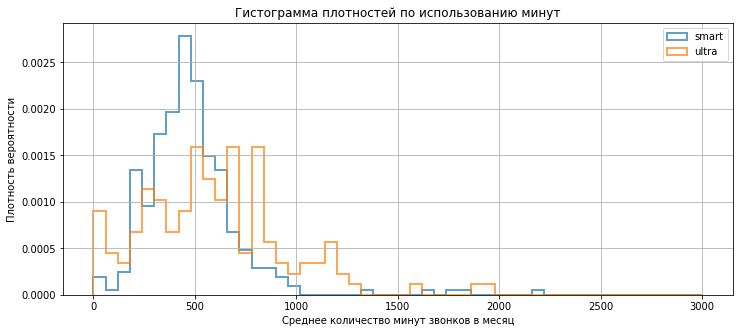

In [54]:
step_hist(data[data.tariff == 'smart'].m_minutes, data[data.tariff == 'ultra'].m_minutes, \
          'smart', 'ultra', (0, 3000), (0, 3000), 50, 50, \
          'Среднее количество минут звонков в месяц', 'Плотность вероятности', 
          'Гистограмма плотностей по использованию минут')

В тариф "Smart" включено только 500 минут, а в тариф "Ultra" - целых 3000 минут. Поэтому неудивительно, что клиенты на тарифе "Ultra" чаще склонны тратить более 500 минут в месяц. 

Среди клиентов на тарифе "Smart" большая часть укладывается в лимит включенных минут. Дисперсия заметно выше среди пользователей тарифа "Ultra":

In [55]:
np.var(data[data.tariff == 'smart'].m_minutes, ddof = 1)

1195473.1286196862

In [56]:
np.var(data[data.tariff == 'ultra'].m_minutes, ddof = 1)

3570438.9625161537

### Использование SMS-сообщений

In [57]:
data[data.tariff == 'smart'].m_messages.describe()

count    351.000000
mean      42.144728
std       70.160528
min        0.000000
25%       11.911923
50%       31.648352
75%       55.549451
max      930.000000
Name: m_messages, dtype: float64

In [58]:
data[data.tariff == 'ultra'].m_messages.describe()

count     149.000000
mean       73.496031
std       139.547083
min         0.000000
25%        17.837838
50%        48.461538
75%        91.111111
max      1550.000000
Name: m_messages, dtype: float64

В тариф "Smart" включено всего 50 сообщений в месяц, а в тариф "Ultra" - целых 1000. Так что здесь та же тенденция, что и с минутами: пользователи "Ultra" в среднем отправляют чуть ли не вдвое больше сообщений, чем пользователи "Smart" (76 против 41, соответственно).

Большинство пользователей "Smart" укладывается в скромный пакет SMS, включенный в тариф. А вот среди клиентов на тарифе "Ultra" много тех, кто не ограничивают себя в общении: дисперсия заметно выше, чем у клиентов на "Smart".

In [59]:
print('Дисперсия распределения среднемесячного количества сообщений на тарифе "Smart":', round(np.var(data[data.tariff == 'smart'].m_messages)))
print('Дисперсия распределения среднемесячного количества сообщений на тарифе "Ultra":', round(np.var(data[data.tariff == 'ultra'].m_messages)))

Дисперсия распределения среднемесячного количества сообщений на тарифе "Smart": 4908
Дисперсия распределения среднемесячного количества сообщений на тарифе "Ultra": 19343


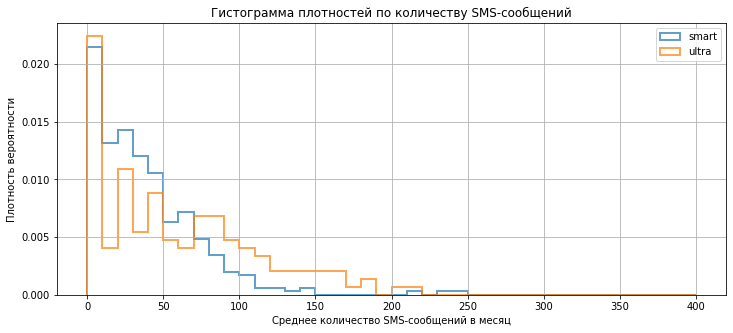

In [60]:
step_hist(data[data.tariff == 'smart'].m_messages, data[data.tariff == 'ultra'].m_messages, \
          'smart', 'ultra', (0, 400), (0, 400), 40, 40, \
          'Среднее количество SMS-сообщений в месяц', 'Плотность вероятности', 'Гистограмма плотностей по количеству SMS-сообщений')

На графике хорошо заметно, что многие абоненты почти не пользуются SMS-сообщениями. С ростом популярности мессенджеров обмен SMS-сообщениями теряет свою актуальность.

### Использование интернет-трафика

In [61]:
data[data.tariff == 'smart'].m_mb_used.describe()

count       351.000000
mean      23047.263576
std       46720.677544
min           0.000000
25%       15001.140839
50%       17674.723404
75%       20426.104972
max      602040.000000
Name: m_mb_used, dtype: float64

In [62]:
data[data.tariff == 'ultra'].m_mb_used.describe()

count       149.000000
mean      28878.827120
std       66781.667668
min           0.000000
25%       16069.578947
50%       21145.542169
75%       29239.385965
max      798210.000000
Name: m_mb_used, dtype: float64

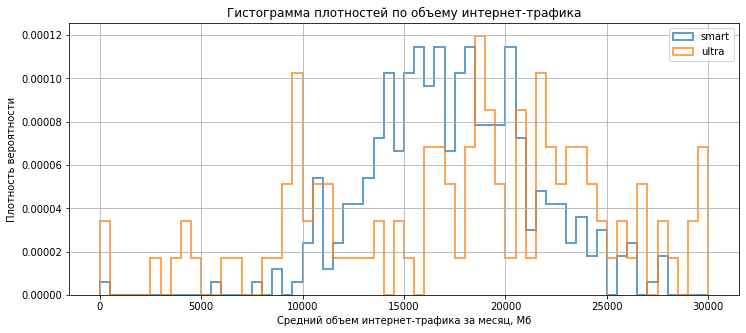

In [63]:
step_hist(data[data.tariff == 'smart'].m_mb_used, data[data.tariff == 'ultra'].m_mb_used, \
          'smart', 'ultra', (0, 30000), (0, 30000), 60, 60, \
          'Средний объем интернет-трафика за месяц, Мб', 'Плотность вероятности', 'Гистограмма плотностей по объему интернет-трафика')

В "Smart" включено 15 Гб, а в "Ultra" - 30 Гб. Только каждый четвертый абонент на тарифе "Smart" укладывается в лимит. Большинству приходится доплачивать за интернет-трафик сверх абонентской платы.

Пользователи "Ultra" в большинстве своем укладываются в лимит своего тарифа (30 Гб), но ведь и абонентская плата у них в 3 с лишним раза выше. 

Интересно, кто же в итоге в выигрыше? Скоро узнаем.

In [64]:
data.groupby('tariff')[['m_minutes', 'm_messages', 'm_mb_used']].agg([np.mean, np.median, np.var]).reset_index()

tariff   m_minutes                           m_messages             \
                mean      median           var       mean     median   
0  smart  584.544367  464.390244  1.195473e+06  42.144728  31.648352   
1  ultra  777.901708  587.368421  3.570439e+06  73.496031  48.461538   

                    m_mb_used                              
            var          mean        median           var  
0   4922.499673  23047.263576  17674.723404  2.182822e+09  
1  19473.388451  28878.827120  21145.542169  4.459791e+09

Итак, мы выяснили, как отличается поведение пользователей двух тарифов по использованию минут, SMS-сообщений и интернет-трафика. Осталось узнать главное: отличаются ли абоненты на тарифах "Smart" и "Ultra" по выручке, которую они приносят "Мегалайну".

## Проверка гипотез<a id = 'hypotheses'></a>

### Гипотеза №1

Проверим гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается:
    - нулевая гипотеза: средняя выручка на двух тарифах одинаковая;
    - альтернативная гипотеза: средняя выручка различается.

Сначала вычислим среднюю выручку пользователей двух тарифов на данных нашей выборки:

In [65]:
data[data.tariff == 'smart'].income.mean()

2737.937939362339

In [66]:
data[data.tariff == 'ultra'].income.mean()

3340.441341807501

Средняя выручка с абонента с тарифом "Ultra" в среднем выше, чем с абонента "Smart". При этом разница не так велика, как можно было бы ожидать, зная, что абонентская плата на тарифе "Ultra" в 3 с лишним раза выше, чем на тарифе "Smart".

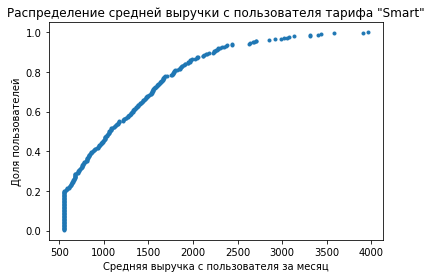

In [67]:
x = np.sort(data[(data.tariff == 'smart') & (data.income < 4000)].income)
y = np.arange(1, len(x) + 1) / len(x)
plt.plot(x, y, marker = '.', linestyle = 'none')
plt.title('Распределение средней выручки с пользователя тарифа "Smart"')
plt.xlabel('Средняя выручка с пользователя за месяц')
plt.ylabel('Доля пользователей');

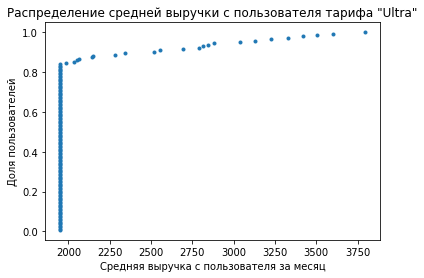

In [68]:
x = np.sort(data[(data.tariff == 'ultra') & (data.income < 4000) & (data.income > 1800)].income)
y = np.arange(1, len(x) + 1) / len(x)
plt.plot(x, y, marker = '.', linestyle = 'none')
plt.title('Распределение средней выручки с пользователя тарифа "Ultra"')
plt.xlabel('Средняя выручка с пользователя за месяц')
plt.ylabel('Доля пользователей');

Больше 80% пользователей тарифа "Smart" тратят больше, чем 550 руб / мес. (размер абонентской платы).

Больше 80% пользователей тарифа "Ultra" ничего не платят сверх абонентской платы (1950 руб / мес.).

У абонентов "Ultra" высокая абонентская плата, а абоненты "Smart" много переплачивают сверх абонентской платы. При этом на обоих тарифах много пользователей, которые тратят сильно больше, чем остальные. В итоге получается, что среднее арифметическое выручки клиентов на тарифах "Smart" и "Ultra" отличается не так уж сильно.

Мы знаем, что средняя выручка с пользователя тарифа "Ultra" выше, чем средняя выручка с пользователя тарифа "Smart". Но наша выборка сравнительно небольшая. Можно ли считать это различие статистически значимым?

In [69]:
np.var(data[data.tariff == 'smart'].income) / np.var(data[data.tariff == 'ultra'].income)

1.1849080620576853

Разница в дисперсии двух выборок небольшая. Учтем это при использовании метода scipy.stats.ttest_ind.

In [70]:
alpha = 0.05
results = st.ttest_ind(data[data.tariff == 'smart'].income, data[data.tariff == 'ultra'].income, equal_var = True)
print('p-значение: ', results.pvalue)
    
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.6100418472230837
Не получилось отвергнуть нулевую гипотезу


Таким образом, по данным нашей выборки у нас нет оснований отвергнуть нулевую гипотезу о равенстве средней выручки с пользователей "Smart" и "Ultra". Если собрать данные по всем клиентам "Мегалайна", может оказаться, что абоненты на тарифе "Smart" приносят компании столько же денег, сколько и абоненты на тарифе "Ultra".

### Гипотеза №2

Проверим вторую гипотезу - о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. В Москве самый высокий уровень зарплат, так что вполне возможно, что люди тратят больше на мобильную связь.

- Нулевая гипотеза: средняя выручка с пользователя из Москвы не отличается от средней выручки с пользователя из другого региона.
- Альтернативная гипотеза: средняя выручка с пользователя из Москвы отличается от средней выручки с пользователя из другого региона.

Сравним средние показатели по москвичам и жителям других городов по нашей выборке, а также оценим дисперсию.

In [71]:
data[data.city == 'Москва'].income.mean()

2081.8559398801704

In [72]:
data[data.city != 'Москва'].income.mean()

3123.786131165491

Как ни странно, по данным нашей выборки москвичи в среднем тратят меньше. Является ли эта разница статистически значимой?

In [73]:
np.var(data[data.city != 'Москва'].income) / np.var(data[data.city == 'Москва'].income)

8.538248956040858

In [74]:
alpha = 0.05
results = st.ttest_ind(data[data.city == 'Москва'].income, data[data.city != 'Москва'].income, equal_var = False)
print('p-значение: ', results.pvalue)
    
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.19682175209704503
Не получилось отвергнуть нулевую гипотезу


Таким образом, у нас нет оснований утверждать, что жители Москвы приносят компании больше денег, чем жители других регионов. Возможно, сделать статистически значимые выводы удастся на большем объеме данных.

Итак, мы проверили две гипотезы и по данным нашей выборки не смогли сделать статистически значимых выводов.

## Выводы<a id = 'summary'></a>

- Абонентская плата на тарифе "Smart" **в 3.5 раза ниже**, чем на "Ultra", и вероятно поэтому **тариф "Smart" пользуется большей популярностью**: в нашей выборке 70% пользователей выбрали именно его.


- **Пользователи тарифа "Ultra" в среднем разговаривают больше, чем пользователи "Smart"**: около 19 минут в день и около 15 минут в день, соответственно. 


- Среди клиентов на тарифе "Smart" большая часть укладывается в пакет включенных минут (500). В тариф "Ultra" включено целых 3000 минут, так что пользователи этого тарифа чаще разговаривают более 500 минут в месяц.


- **Пользователи "Ultra" в среднем отправляют чуть ли не вдвое больше сообщений, чем пользователи "Smart"** (76 против 41, соответственно).


- При этом **многие абоненты вообще почти не пользуются SMS-сообщениями**. С ростом популярности мессенджеров обмен SMS-сообщениями теряет свою актуальность.


- Если минут и сообщений, включенных в абонентскую плату, большинству абонентов на тарифе "Smart" достаточно, то с интернет-трафиком ситуация иная. Только каждый четвертый абонент укладывается в лимит 15 Гб. **Большинству абонентов на тарифе "Smart" приходится доплачивать за интернет-трафик сверх абонентской платы**.


- **Большинство (более 80%) пользователей тарифа "Smart" тратят больше, чем 550 руб / мес. (размер абонентской платы)**. Большинство (более 80%) пользователей тарифа "Ultra" ничего не платят сверх абонентской платы (1950 руб / мес.).


- У абонентов "Ultra" высокая абонентская плата, а абоненты "Smart" много переплачивают сверх абонентской платы. При этом на обоих тарифах много пользователей, которые тратят сильно больше, чем остальные. В итоге получается, что **средние показатели выручки с клиентов на тарифах "Smart" и "Ultra" сопоставимы между собой**.


- По данным нашей выборки **нет оснований отвергнуть нулевую гипотезу о равенстве средней выручки с пользователей "Smart" и "Ultra"**.


- После проведения статистического текста у нас также **нет оснований утверждать, что жители Москвы приносят компании больше денег, чем жители других регионов**. 